# **Target y Exploración de Datos**


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings("ignore")



## **Preprocesamiento de Datos**

En primer lugar, leemos la base de datos desde el csv. Debido al tamaño del archivo se optó por acceder por fragmentos al archivo, con el objetivo de optimizar el uso de memoria.

In [3]:

# archivo original
input_file = r"c:\Users\TAWTOCA\Downloads\accepted_2007_to_2018Q4.csv"

# tamaño de los bloques
chunksize = 200000  

# lista para guardar los fragmentos
df_list = []

for chunk in pd.read_csv(input_file, chunksize=chunksize, low_memory=False):
    df_list.append(chunk)   # guardamos cada bloque

# concatenar todos los fragmentos en un único DataFrame
df = pd.concat(df_list, ignore_index=True)

print("✅ Dataset cargado con forma:", df.shape)
print("🔍 Columnas disponibles:\n", df.columns.tolist())


✅ Dataset cargado con forma: (2260701, 151)
🔍 Columnas disponibles:
 ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_in

### **Creación Variable 'Default'**

Se creó la variable binaria 'default' en base a la variable original 'loan_status'.  Se tiene 'Fully Paid' = 0 y 'Charge Off'/'Default' = 1. Luego se elimina aquellos registros en los que 'default' seria nula.

In [4]:
# Definir categorías
good_status = ["Fully Paid"]
bad_status = ["Charged Off", "Default"]

# Crear nueva variable sin reemplazar la original
df["default"] = df["loan_status"].apply(lambda x: 1 if x in bad_status else (0 if x in good_status else None))

# Filtrar para conservar solo Fully Paid y Charged Off/Default
df = df[df["default"].notnull()].copy()

# Verificar resultados
print(df["loan_status"].value_counts())
print(df["default"].value_counts())

loan_status
Fully Paid     1076751
Charged Off     268559
Default             40
Name: count, dtype: int64
default
0.0    1076751
1.0     268599
Name: count, dtype: int64


In [4]:
print(df.shape)

(1345350, 152)


### **Elección de variables**

Para elegir las variables más relevantes para el modelado se utilizó varias estrategias con el fin de optimizar el proceso. 

1. Eliminar aquellas variables con un porcentaje de valores nulos mayor al 50%. Justificado en el hecho de que no aportaría a los resultados.

In [5]:
null_thresh = 0.5
df = df.loc[:, df.isnull().mean() < null_thresh]
print("✅ Después de eliminar nulos (>50%):", df.shape)

✅ Después de eliminar nulos (>50%): (1345350, 94)


2. Eliminar variables con baja variabilidad. Es decir, aquellas donde más del 95% de las filas tiene el mismo valor.

In [5]:
low_variance_cols = [col for col in df.columns 
                     if df[col].nunique(dropna=True) <= 1 or 
                        (df[col].value_counts(normalize=True, dropna=False).iloc[0] > 0.95)]
df.drop(columns=low_variance_cols, inplace=True)
print("✅ Después de baja varianza:", df.shape)

✅ Después de baja varianza: (1345350, 100)


3. Eliminar variables de Data Leakage (fuga de información)

In [7]:
leakage_cols = [
    'funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
    'total_rec_int','recoveries','collection_recovery_fee','last_pymnt_d',
    'last_pymnt_amnt','last_credit_pull_d','last_fico_range_high','last_fico_range_low'
]
df.drop(columns=[c for c in leakage_cols if c in df.columns], inplace=True, errors="ignore")
print("✅ Después de quitar leakage:", df.shape)

✅ Después de quitar leakage: (1345350, 67)


4. Se eliminan las variables que contienen metadatos/identificadores que no aportan al analisis. 

In [8]:

id_cols = ["id", "zip_code", "url"]
df.drop(columns=[c for c in id_cols if c in df.columns], inplace=True, errors="ignore")
print("✅ Después de quitar IDs/metadatos:", df.shape)

✅ Después de quitar IDs/metadatos: (1345350, 64)


5. Se modificaron aquellas variables con colinealidad extrema (pares obvios). Para evitar información redundante,

In [9]:
if 'fico_range_high' in df.columns and 'fico_range_low' in df.columns:
    df['fico_mean'] = (df['fico_range_high'] + df['fico_range_low']) / 2
    df.drop(columns=['fico_range_high','fico_range_low'], inplace=True)

if 'grade' in df.columns and 'sub_grade' in df.columns:
    df.drop(columns=['grade'], inplace=True)

if 'funded_amnt' in df.columns and 'loan_amnt' in df.columns:
    df.drop(columns=['funded_amnt'], inplace=True)

print("✅ Después de manejar colinealidad:", df.shape)

✅ Después de manejar colinealidad: (1345350, 62)


In [10]:
if 'loan_status' in df.columns:
    df.drop(columns=['loan_status'], inplace=True)

6. Eliminar texto libre difícil de procesar

In [11]:

text_cols = [ "emp_title", "title"]
df.drop(columns=[c for c in text_cols if c in df.columns], inplace=True, errors="ignore")
print("✅ Después de quitar texto libre:", df.shape)

✅ Después de quitar texto libre: (1345350, 59)


In [12]:
# Convertir earliest_cr_line al formato datetime correcto
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")

# Crear columnas de año y mes
df["earliest_cr_line_year"] = df["earliest_cr_line"].dt.year
df["earliest_cr_line_month"] = df["earliest_cr_line"].dt.month

# Eliminar la original
df.drop(columns=["earliest_cr_line"], inplace=True)


In [13]:
print("✅ Dataset final shape:", df.shape)
print("📌 Columnas finales:\n", df.columns.tolist())

✅ Dataset final shape: (1345350, 60)
📌 Columnas finales:
 ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_i

Como se busca predecir si un préstamo emitido resultará en default (1) o será pagado completamente (0), se necesita la información relevante con el prestatario, por lo que aquello que no aporta tambien sera eliminado. Asi como columnas redundantess y tecnicas irrelavantes.

In [14]:
irrelevant_cols = [
    "issue_d",            # fecha de emisión (introduce sesgo temporal)
    "initial_list_status" # estado inicial de la publicación (plataforma, no prestatario)
]
df.drop(columns=[c for c in irrelevant_cols if c in df.columns], inplace=True)


In [15]:
# === 3. Eliminar numéricas redundantes ===
redundant_cols = [
    "installment",        # muy correlacionada con loan_amnt e int_rate
    "avg_cur_bal",        # duplicada con tot_cur_bal
    "total_bal_ex_mort",  # redundante con tot_cur_bal
    "total_bc_limit",     # redundante con total_rev_hi_lim
    "total_il_high_credit_limit", # redundante con tot_hi_cred_lim
    "bc_open_to_buy"      # redundante con bc_util
]
df.drop(columns=[c for c in redundant_cols if c in df.columns], inplace=True)

In [16]:
# lista de columnas técnicas a eliminar
cols_drop = [
    "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "tot_hi_cred_lim",
    "total_bal_ex_mort", "total_bc_limit", "total_il_high_credit_limit",
    "bc_open_to_buy", "bc_util", "percent_bc_gt_75", "pct_tl_nvr_dlq",
    "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl", "mths_since_recent_bc", "mths_since_recent_inq",
    "acc_open_past_24mths", "avg_cur_bal", "num_accts_ever_120_pd",
    "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl",
    "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", 'clean_emp_length', 'emp_length'
]

# eliminar columnas
df = df.drop(columns=cols_drop, errors="ignore")

print("✅ Dataset reducido:", df.shape)
print("📌 Columnas finales:", df.columns.tolist())


✅ Dataset reducido: (1345350, 23)
📌 Columnas finales: ['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'default', 'fico_mean', 'earliest_cr_line_year', 'earliest_cr_line_month']


Al final, terminamos con un total de 24 variables y 1345350 registros. Por lo que se procede a realizar el análisis exploratorio de datos.

In [17]:
# === 4. Porcentaje de nulos en las columnas restantes ===
null_percent = df.isnull().mean().sort_values(ascending=False) * 100

print("✅ Shape final:", df.shape)
print("📌 Columnas finales:\n", df.columns.tolist())

print("\n📊 Porcentaje de nulos por variable:")
print(null_percent)

✅ Shape final: (1345350, 23)
📌 Columnas finales:
 ['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'default', 'fico_mean', 'earliest_cr_line_year', 'earliest_cr_line_month']

📊 Porcentaje de nulos por variable:
mort_acc                  3.514401
revol_util                0.063701
pub_rec_bankruptcies      0.051808
dti                       0.027799
inq_last_6mths            0.000074
term                      0.000000
loan_amnt                 0.000000
verification_status       0.000000
annual_inc                0.000000
home_ownership            0.000000
sub_grade                 0.000000
int_rate                  0.000000
delinq_2yrs               0.000000
addr_state                0.000000
purpose                   0.000000
revol_bal                 0.000000
pub_rec     

In [18]:
df.to_pickle(r"c:\Users\TAWTOCA\Downloads\df.pkl")
df.to_csv(r"c:\Users\TAWTOCA\Downloads\df.csv", index=False)


## **Analisis Exploratorio de Datos**

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_palette("Blues")

# ----------------------------
# 1. Distribución de la variable objetivo (default)
# ----------------------------
def plot_default_distribution(df):
    plt.figure(figsize=(5,5))
    df["default"].value_counts().plot(
        kind="pie", 
        autopct="%1.1f%%", 
        startangle=90, 
        colors=sns.color_palette("Blues", 2),
        wedgeprops={"edgecolor":"white"}
    )
    plt.title("Distribución de la variable objetivo (default)")
    plt.ylabel("")
    plt.show()

# ----------------------------
# 2. Variables numéricas
# ----------------------------
def plot_numeric(df, col):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    # Histograma
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    # Boxplot por clase default
    sns.boxplot(x="default", y=col, data=df, ax=axes[1], palette="Blues")
    axes[1].set_title(f"{col} vs Default")
    axes[1].set_xlabel("Default")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# ----------------------------
# 3. Variables categóricas


def plot_categorical(df, var, target="default"):
    plt.figure(figsize=(8,6))
    counts = df[var].value_counts().sort_values(ascending=False)
    n_cats = len(counts)

    # Caso 1: 2 categorías → gráfico de anillo
    if n_cats == 2:
        counts.plot.pie(
            autopct="%1.1f%%",
            startangle=90,
            colors=sns.color_palette("Blues", n_colors=n_cats),
            wedgeprops=dict(width=0.4)
        )
        plt.ylabel("")
        plt.title(f"Distribución de {var}")

    # Caso 2: hasta 6 categorías → circular normal
    elif n_cats <= 6:
        counts.plot.pie(
            autopct="%1.1f%%",
            startangle=90,
            colors=sns.color_palette("Blues", n_colors=n_cats)
        )
        plt.ylabel("")
        plt.title(f"Distribución de {var}")

    # Caso 3: más de 6 y hasta 10 → barras verticales
    elif n_cats <= 10:
        sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
        plt.title(f"Distribución de {var}")
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha="right")

    # Caso 4: más de 10 → Solo Top 10 por clase default
    else:
        for cls in df[target].unique():
            subset = df[df[target] == cls][var].value_counts().head(10)
            plt.figure(figsize=(8,6))
            sns.barplot(y=subset.index, x=subset.values, palette="Blues_r")
            plt.title(f"Top 10 categorías de {var} | {target}={cls}")
            plt.xlabel("Frecuencia")
            plt.tight_layout()
            plt.show()
        return

    plt.tight_layout()
    plt.show()


### **Distribución de la Variable Default**

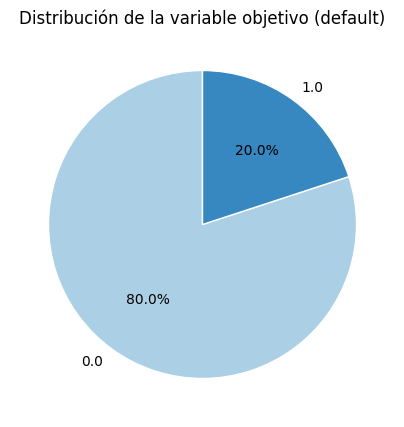

In [20]:
# Target
plot_default_distribution(df)

Este gráfico revela un desbalance de clases, ya que la mayoría de los casos corresponde a clientes que no cayeron en default. Este desbalance puede afectar el desempeño de modelos de clasificación, ya que podrían inclinarse a predecir mayormente la clase mayoritaria.

### **Valores Faltantes y Tipos de Datos**


Valores faltantes por columna:


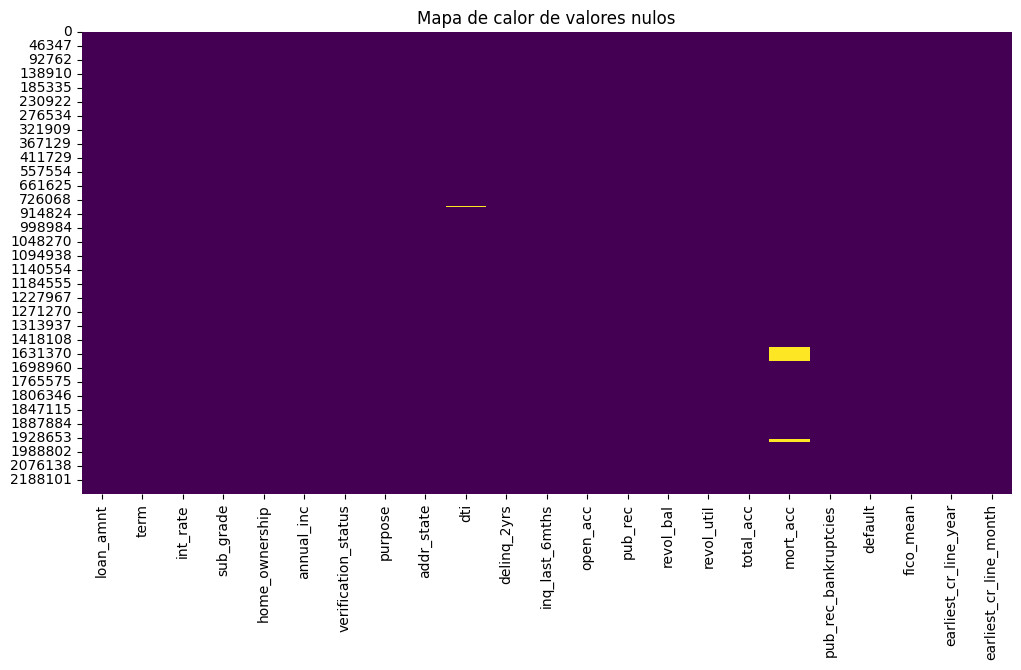


Tipos de datos:


loan_amnt                 float64
term                       object
int_rate                  float64
sub_grade                  object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
addr_state                 object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
mort_acc                  float64
pub_rec_bankruptcies      float64
default                   float64
fico_mean                 float64
earliest_cr_line_year       int32
earliest_cr_line_month      int32
dtype: object

In [21]:

print("\nValores faltantes por columna:")
df.isnull().sum()


plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos")
plt.show()

print("\nTipos de datos:")
df.dtypes

En general, el conjunto de datos está bien completo, ya que la mayoría de las variables no presentan valores nulos. Sin embargo, se observan algunos valores faltantes concentrados en tres columnas: mort_acc, pub_rec_bankruptcies y revol_util. Estas columnas tienen pocos casos nulos en comparación con el tamaño total del dataset, lo que sugiere que podrían ser imputados fácilmente (por ejemplo, con la media, mediana o un modelo de predicción), o eliminados sin afectar significativamente el análisis.

### **Histogramas Variables Númericas**

Para el analisis de las variables numericas se muestran un histograma para visualizar su distribución y 

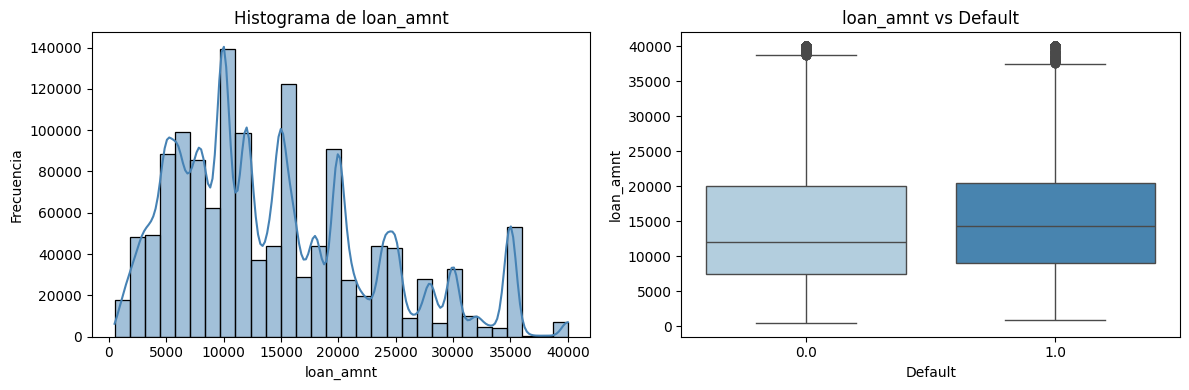

In [22]:
# loan_amnt
plot_numeric(df, "loan_amnt")


El análisis muestra que la mayoría de los préstamos otorgados se concentran entre los 5,000 y 20,000 dólares, con picos específicos que sugieren montos estandarizados por la entidad financiera. Al comparar con la variable Default, se observa que los clientes que incumplen tienden a tener montos de préstamo ligeramente más altos que los que no incumplen, aunque la diferencia no es muy marcada. Esto indica que el monto del préstamo podría influir en el riesgo de incumplimiento, pero no parece ser un factor determinante por sí solo.

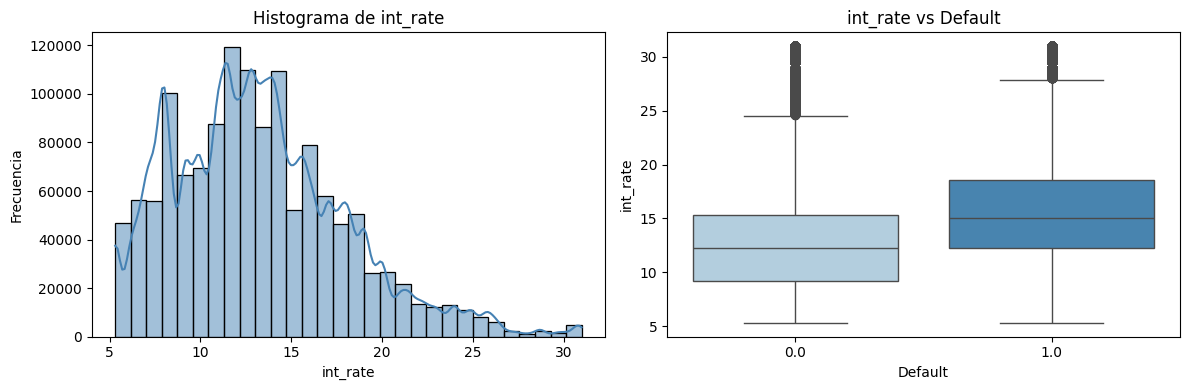

In [23]:
# int_rate
plot_numeric(df, "int_rate")


La distribución de las tasas de interés está concentrada entre el 8% y el 16%, disminuyendo progresivamente en valores más altos. El boxplot revela que los préstamos en Default suelen tener tasas de interés más elevadas en comparación con los que no incumplen, lo que respalda la relación entre riesgo percibido y costo del crédito: a mayor tasa, mayor probabilidad de incumplimiento. En este caso, la tasa de interés se presenta como un indicador clave para predecir el default.

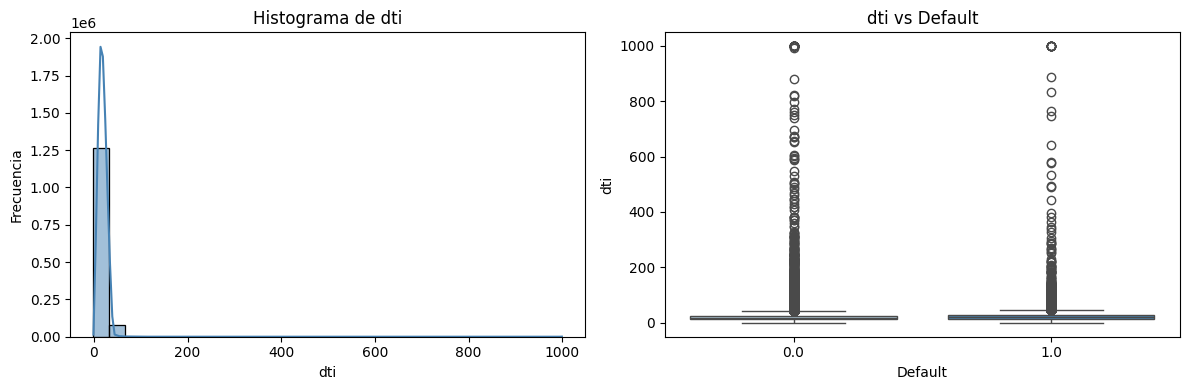

In [24]:
# dti
plot_numeric(df, "dti")


El histograma de la variable dti (debt-to-income ratio) muestra que la gran mayoría de los clientes tienen un valor relativamente bajo, concentrado entre 0 y 40, aunque existen valores extremos que llegan a superar los 1000, lo cual resulta poco común y probablemente corresponda a outliers o datos atípicos. El boxplot refleja esta misma situación: la distribución central es bastante compacta, pero hay una gran cantidad de valores atípicos en ambos grupos de Default.

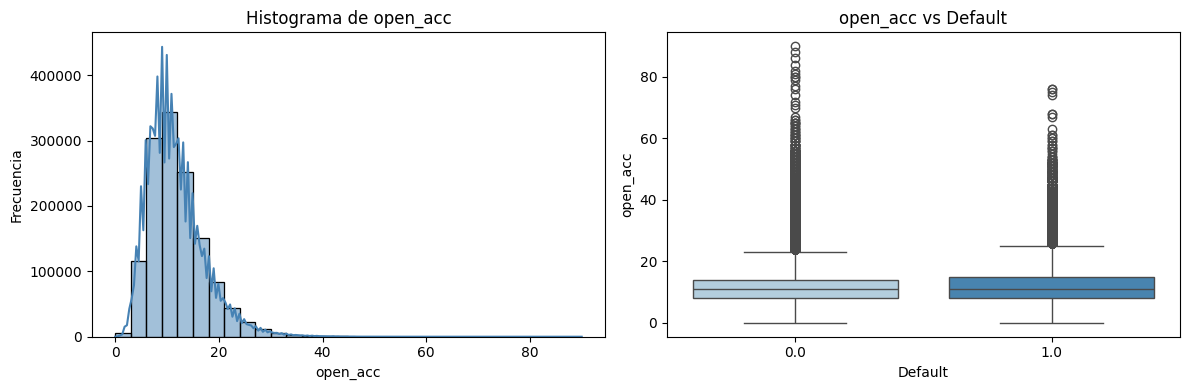

In [25]:
# open_acc
plot_numeric(df, "open_acc")


El histograma de open_acc muestra que la mayoría de los clientes tienen entre 5 y 20 cuentas abiertas, con un claro sesgo a la derecha y algunos casos extremos que superan incluso las 60 cuentas. Esto indica que aunque la mayor parte de las personas mantiene un número moderado de cuentas de crédito abiertas, existe una minoría con una cantidad inusualmente alta. En el boxplot, se aprecia que tanto los clientes que incumplen (Default = 1) como los que no incumplen (Default = 0) tienen distribuciones bastante parecidas, con medianas cercanas y un rango intercuartílico similar.

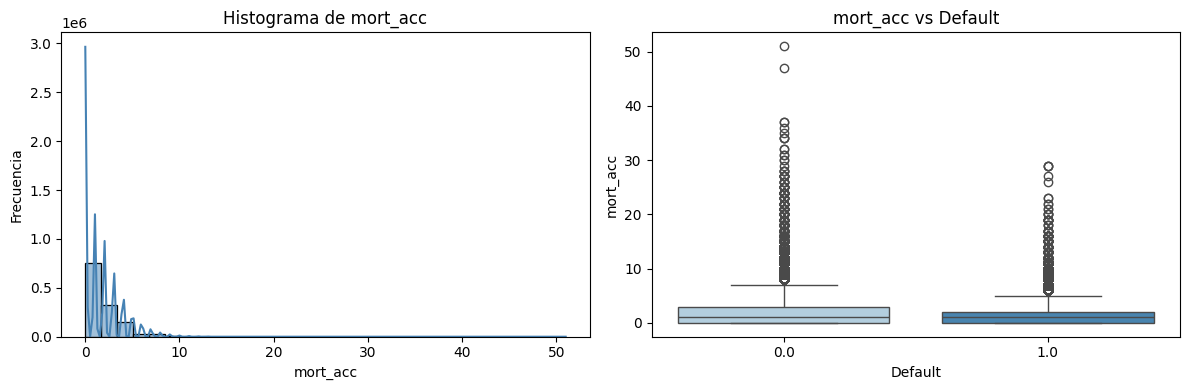

In [26]:
# mort_acc
plot_numeric(df, "mort_acc")


En la variable mort_acc, el histograma evidencia que la mayoría de los clientes tienen entre 0 y 2 cuentas hipotecarias, y que muy pocos superan este rango, mostrando también un sesgo hacia la derecha con valores atípicos que llegan hasta más de 40. El boxplot refleja que los clientes en Default suelen tener una mediana más baja de cuentas hipotecarias en comparación con los que no incumplen, lo que puede indicar que los clientes con más cuentas hipotecarias suelen ser más solventes o tienen más respaldo financiero.

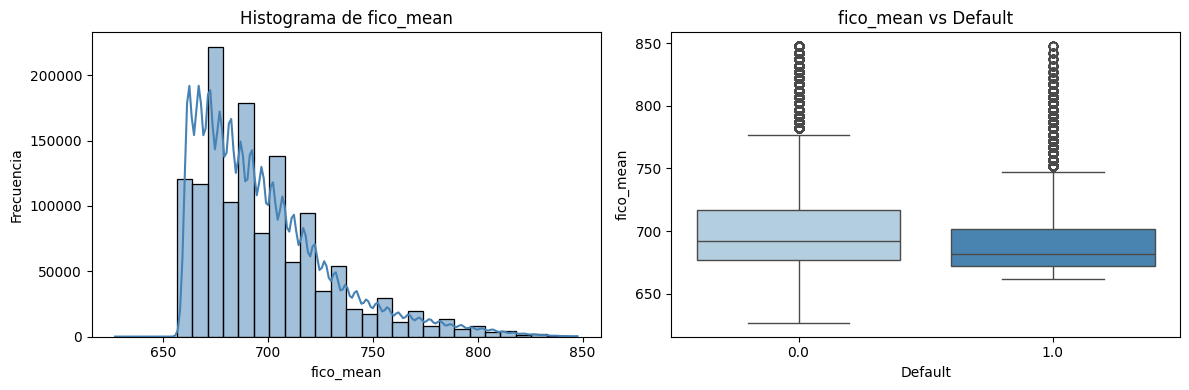

In [27]:
# fico_mean
plot_numeric(df, "fico_mean")


En el caso de fico_mean, el histograma muestra una distribución más simétrica, concentrada entre 660 y 720 puntos, aunque con valores que llegan hasta los 850. Esto refleja que la mayoría de los clientes tienen un puntaje crediticio dentro del rango considerado aceptable a bueno. El boxplot revela una diferencia más marcada entre los dos grupos: los clientes que incumplen presentan una mediana más baja en comparación con los que no incumplen. Además, aunque ambos grupos tienen outliers con puntajes altos, la tendencia general indica que un menor fico_mean está asociado con mayor probabilidad de caer en Default.

### **Variables Categoricas** 

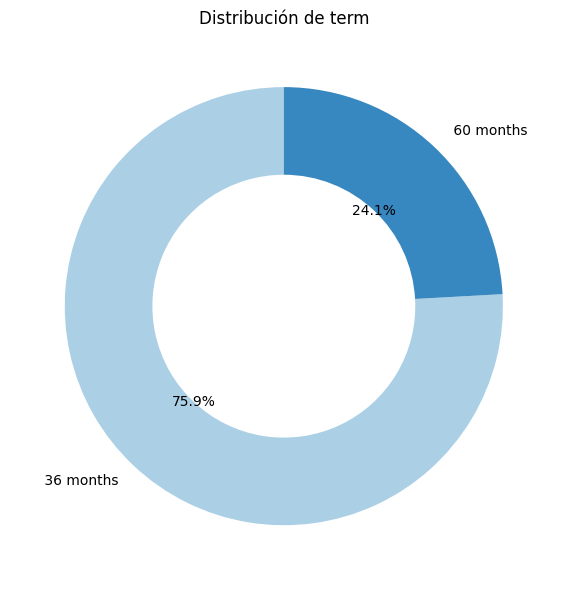

In [28]:
# term
plot_categorical(df, "term")


La distribución de la variable term muestra que la mayoría de los préstamos tienen un plazo de 36 meses (75.9%), mientras que solo una cuarta parte corresponde a 60 meses (24.1%). Esto refleja una preferencia clara por préstamos de corto plazo, lo cual es consistente con un menor riesgo de incumplimiento, ya que los plazos más cortos suelen implicar un menor nivel de exposición y, en general, menor probabilidad de Default. Sin embargo, la existencia de un porcentaje significativo de préstamos a 60 meses indica que una parte importante de los clientes está dispuesta a asumir un compromiso financiero más prolongado.

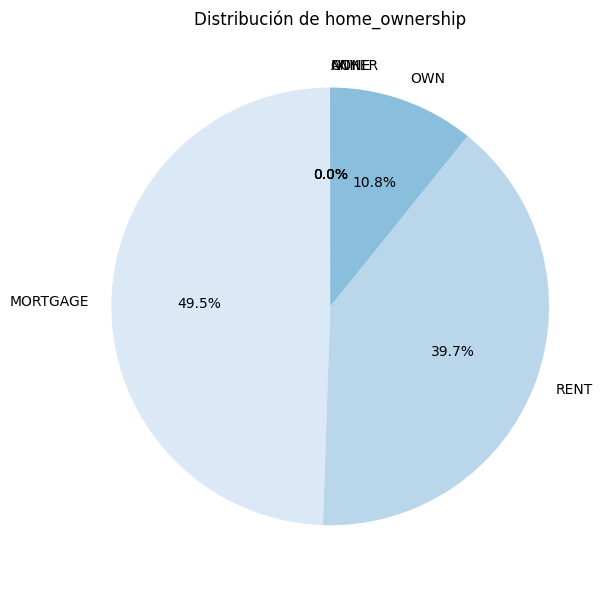

In [29]:
plot_categorical(df, "home_ownership")


En la variable home_ownership, se observa que la mayoría de los clientes se concentran en tres categorías principales: MORTGAGE (hipoteca), RENT (arriendo) y OWN (propiedad), siendo las dos primeras las más frecuentes. Esto sugiere que la base de clientes incluye tanto personas con vivienda propia hipotecada como arrendatarios en proporciones muy similares. Los casos de ANY, OTHER y NONE son minoritarios, lo que indica situaciones menos comunes de tenencia de vivienda.

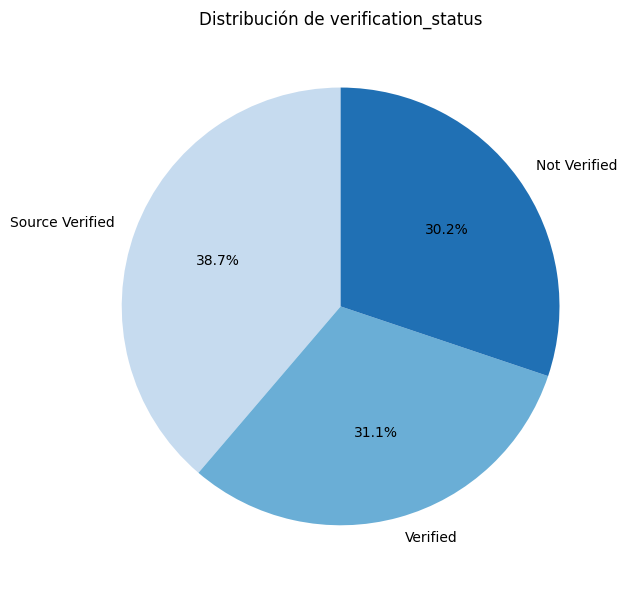

In [30]:
# verification_status
plot_categorical(df, "verification_status")


La variable verification_status muestra que la mayoría de los clientes tienen algún grado de verificación de sus ingresos: Source Verified (38.7%) y Verified (31.1%), mientras que un 30.2% no tiene verificación (Not Verified). El hecho de que casi el 70% de los casos cuente con verificación sugiere que la entidad crediticia otorga importancia a este proceso para reducir el riesgo de fraude o de información falsa. 

<Figure size 800x600 with 0 Axes>

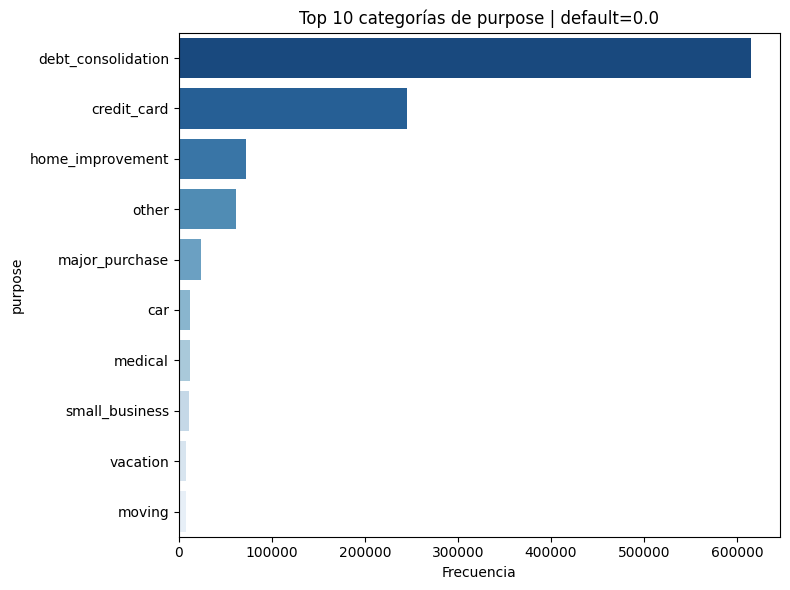

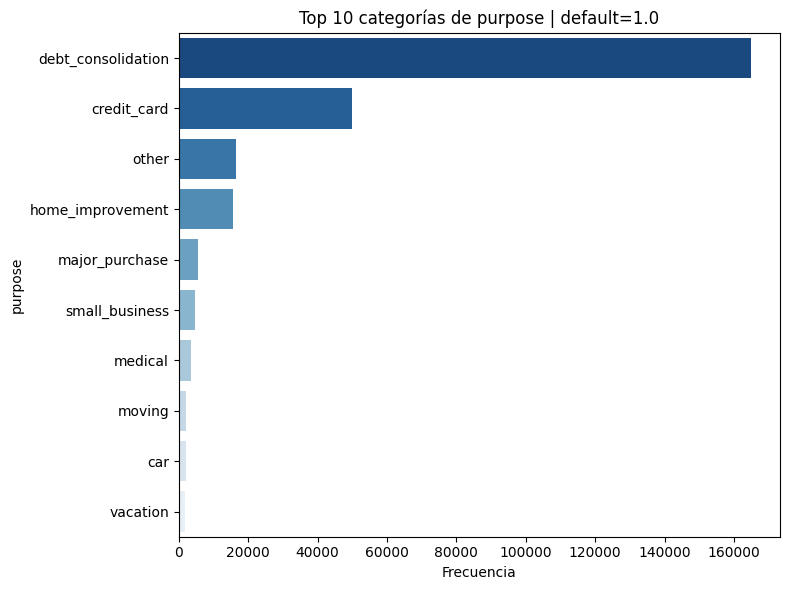

In [31]:
# purpose
plot_categorical(df, "purpose")


En el primer gráfico se observa que la mayoría de los préstamos concedidos a clientes que no cayeron en Default se concentran principalmente en la categoría debt_consolidation (consolidación de deudas), que supera con creces a todas las demás con más de 600,000 registros. En segundo lugar se encuentra credit_card, que también representa un volumen significativo de clientes con cerca de 250,000 casos. Las siguientes categorías como home_improvement, other y major_purchase tienen una participación mucho menor en comparación, y las categorías car, medical, small_business, vacation y moving son aún menos frecuentes. Esto indica que los préstamos relacionados con el manejo de deudas y tarjetas de crédito son los más comunes entre los clientes cumplidos.

En el segundo gráfico, que muestra los clientes que sí cayeron en Default, la distribución se mantiene con un patrón muy similar al de los cumplidos: debt_consolidation sigue siendo la categoría dominante, seguida de credit_card. Sin embargo, proporcionalmente, las categorías de other y home_improvement adquieren mayor peso dentro del grupo en incumplimiento, lo que sugiere que estos propósitos pueden conllevar un mayor riesgo relativo de no pago. Al igual que en los clientes sin Default, las categorías de menor frecuencia siguen siendo vacation, car y moving, lo que indica que no representan un volumen significativo de incumplimientos, aunque podrían ser riesgosas en casos particulares por el tipo de gasto que implican.

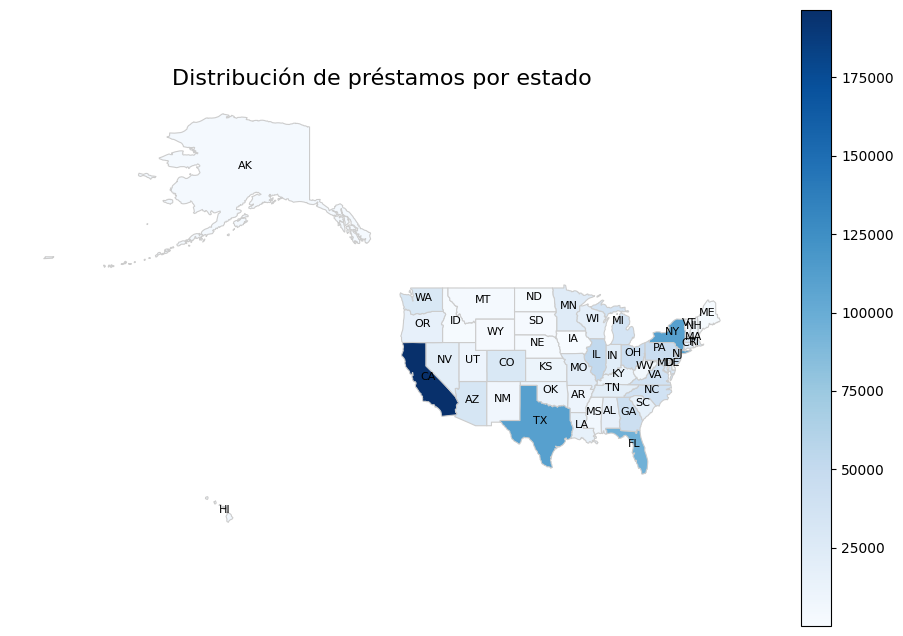

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

def plot_us_states_matplotlib(df, col="addr_state"):
    # Mapeo de códigos de estados a nombres completos
    state_map = {
        "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
        "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
        "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
        "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
        "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
        "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
        "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
        "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
        "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
        "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
        "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah",
        "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
        "WI": "Wisconsin", "WY": "Wyoming"
    }

    # Contar préstamos por estado
    df_state_counts = df[col].value_counts().reset_index()
    df_state_counts.columns = ["state_abbr", "count"]
    df_state_counts["state"] = df_state_counts["state_abbr"].map(state_map)

    # Leer shapefile de estados de EE.UU. desde un GeoJSON público
    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    states = gpd.read_file(url)

    # Unir con nuestros datos
    merged = states.merge(df_state_counts, left_on="name", right_on="state", how="left")

    # Graficar
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged.plot(column="count", cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
    ax.set_title("Distribución de préstamos por estado", fontsize=16)
    ax.axis("off")

    # Agregar etiquetas con siglas
    for idx, row in merged.iterrows():
        if row["state_abbr"] in state_map.keys():  # evitar NaN
            plt.annotate(
                text=row["state_abbr"],
                xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
                ha="center", fontsize=8, color="black"
            )

    plt.show()


    
# Llamar a la función para graficar
plot_us_states_matplotlib(df, col="addr_state")


In [49]:
import plotly.express as px

def plot_us_states_interactive(df, col="addr_state"):
    state_counts = df[col].value_counts().reset_index()
    state_counts.columns = ["state", "count"]

    fig = px.choropleth(
        state_counts,
        locations="state",
        locationmode="USA-states",
        color="count",
        scope="usa",
        color_continuous_scale="Blues",
        title="Distribución de préstamos por estado"
    )
    fig.show()
plot_us_states_interactive(df, col="addr_state")

El mapa de calor por estados muestra que la mayor concentración de préstamos se da en California, seguido por Texas, Florida y Nueva York. Estos estados destacan no solo por el número de préstamos, sino también porque representan las zonas con mayor densidad de población y actividad económica en Estados Unidos, lo que explica en gran medida la mayor demanda de crédito. En contraste, estados menos poblados como los del medio oeste y noroeste presentan una frecuencia significativamente menor de préstamos. Esta distribución geográfica permite identificar áreas clave para el mercado crediticio, a la vez que sugiere que el riesgo de incumplimiento podría variar según las condiciones económicas y demográficas locales.

### **Matriz de Correlación**

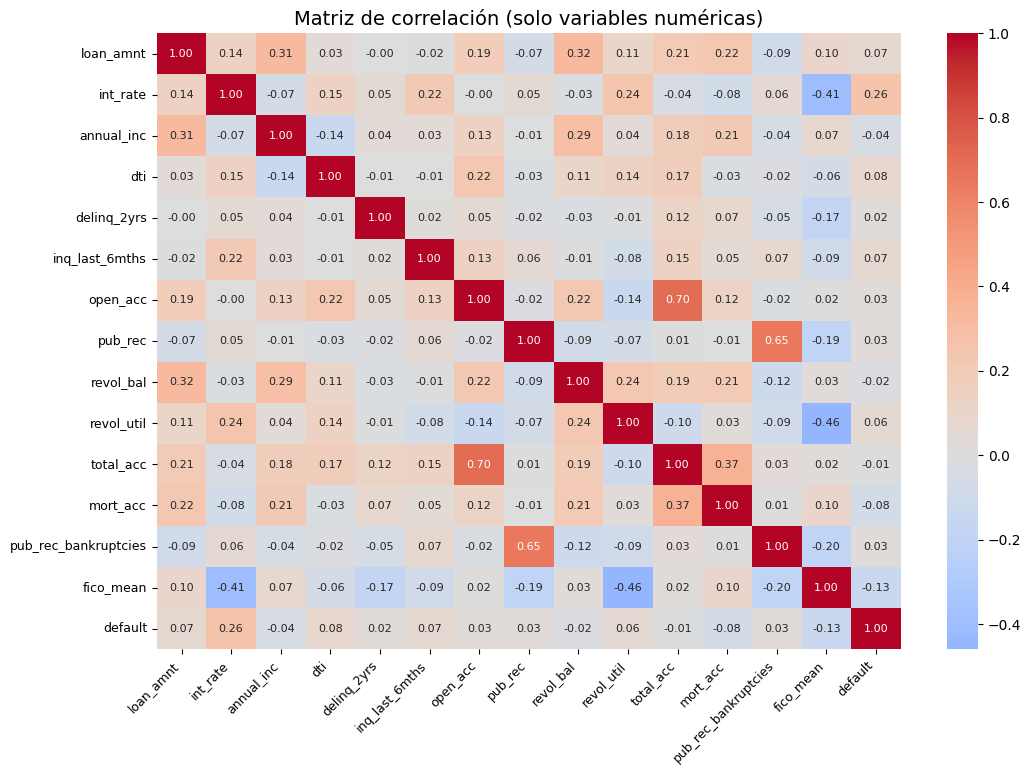

In [34]:
# ----------------------------
# 1. Variables numéricas finales
# ----------------------------
num_cols = [
    "loan_amnt", "int_rate", "annual_inc", "dti", "delinq_2yrs", 
    "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", 
    "total_acc", "mort_acc", "pub_rec_bankruptcies", "fico_mean"
]

# ----------------------------
# 2. Subset de dataframe con numéricas + default
# ----------------------------
df_corr = df[num_cols + ["default"]]

# ----------------------------
# 3. Matriz de correlación con índices
# ----------------------------
plt.figure(figsize=(12,8))
corr = df_corr.corr()
sns.heatmap(
    corr, 
    cmap="coolwarm", 
    center=0, 
    cbar=True, 
    annot=True,       # valores dentro de cada celda
    fmt=".2f",        # formato numérico
    annot_kws={"size":8}  # tamaño de fuente de los números
)
plt.title("Matriz de correlación (solo variables numéricas)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.show()




Se observa que la mayoría de las correlaciones con la variable objetivo default (incumplimiento) son bajas, siendo la más destacada la tasa de interés (int_rate) con una correlación positiva de 0.26, lo que sugiere que a mayor tasa, mayor probabilidad de incumplimiento. También destaca una correlación negativa entre el puntaje FICO (fico_mean) y default (-0.13), indicando que personas con mejor historial crediticio tienden a incumplir menos. Por otro lado, algunas variables están fuertemente correlacionadas entre sí, como total_acc con open_acc (0.70), lo que puede señalar redundancia en los datos.